In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dive-into-graphs
!pip install pydig


1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
import dgl
import dgl.function as fn
from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
from dgl.dataloading import GraphDataLoader
from dgl.nn import AvgPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset


#. DIG
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.method import PGExplainer
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
from dig.xgraph.models import GCN_2l

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
Explainability_name = 'PGExplainer'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [90]:
#dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
#dataset = GINDataset('MUTAG', self_loop=False)


In [91]:
#print('Number of Graphs: ', len(dataset))
#print("Number of Features: ", dataset.dim_nfeats)
#print("Self Loop: ", dataset.self_loop)
data = dataset[0]
print(data)
#print(dataset.labels)

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [92]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=1000)
#train_dataset = dataset[:150]
#test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 131
Number of test graphs: 57


# **Batching Data by DataLoader**

In [93]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

torch.manual_seed(123456)
#train_dataloader = GraphDataLoader(train_dataset, batch_size=64, shuffle=True)
#test_dataloader = GraphDataLoader(test_dataset, batch_size=64, shuffle=False)
#dataset_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [94]:
print(train_dataset[0])
#print(train_dataset[0][0])
#print(train_dataset[0][0])
print(train_dataset[0])
######print(GCN_Model(dataset[0].x, dataset[0].edge_index))

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])
Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


In [95]:
for bg in train_dataloader:
  #print(bg)
  print(len(bg[0].ndata['attr']))
  print(len(bg[0].ndata['label']))
  

NameError: ignored

In [96]:
feat_size = train_dataset[0].x.shape[1]
print(feat_size)
#DGL_Model = Graph_Model(feat_size, dataset.gclasses)

7


# **Model Designing**

In [97]:
class Graph_Model(nn.Module):
  def __init__(self, in_feats, out_feats):
    super(Graph_Model, self).__init__()
    self.linear = nn.Linear(in_feats, out_feats)
    self.linear2 = nn.Linear(out_feats, out_feats)
    self.pool = AvgPooling()

  def forward(self, graph, feat, eweight=None):
    with graph.local_scope():
        feat = self.linear(feat)
        feat = self.linear2(feat)
        graph.ndata['h'] = feat
        if eweight is None:
            graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
        else:
            graph.edata['w'] = eweight
            graph.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
        return self.pool(graph, graph.ndata['h'])

In [98]:
GCN_Model = GCN_2l(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, num_classes=2)

In [99]:
print(GCN_Model)

GCN_2l(
  (conv1): GCNConv(7, 7)
  (convs): ModuleList(
    (0): GCNConv(7, 7)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): GlobalMeanPool()
  (ffn): Sequential(
    (0): Linear(in_features=7, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


In [100]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01)

In [101]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [102]:
def loading_model(load_index):
  GCN_Model = GCN_2l(feat_size, dataset.gclasses)
  GCN_Model_optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model_Optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [103]:
def visualize_losses(grad_cam_losses, epoch_history):
  grad_cam_losses_list = torch.stack(grad_cam_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(str(Explainability_name) + " Loss in Epoch: " + str(epoch_history))

  ax.plot(grad_cam_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  




# **Traning Configurations**

In [104]:
def train_step():
  GCN_Model_loss_batch = []

  GCN_Model.train()
  GCN_Model.zero_grad()
  for g in train_dataset:
    logits = GCN_Model(g.x, g.edge_index)
    #print('done')
    #print(bg.ndata['attr'])
    batch_loss = loss_calculations(logits, g.y)
    GCN_Model_loss_batch.append(batch_loss)

    batch_loss.backward()
    GCN_Model_Optimizer.step()
  
  return torch.mean(torch.tensor(GCN_Model_loss_batch))


In [105]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [106]:
def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss = train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss





Epoch: 001, PGExplainer Model Loss: 0.6505
Epoch: 002, PGExplainer Model Loss: 0.7852
Epoch: 003, PGExplainer Model Loss: 0.6760
Epoch: 004, PGExplainer Model Loss: 0.8084
Epoch: 005, PGExplainer Model Loss: 0.7114
Epoch: 006, PGExplainer Model Loss: 0.7812
Epoch: 007, PGExplainer Model Loss: 0.6682
Epoch: 008, PGExplainer Model Loss: 0.7058
Epoch: 009, PGExplainer Model Loss: 0.6492
Epoch: 010, PGExplainer Model Loss: 0.6902
Epoch: 011, PGExplainer Model Loss: 0.6449
Epoch: 012, PGExplainer Model Loss: 0.6950
Epoch: 013, PGExplainer Model Loss: 0.6483
Epoch: 014, PGExplainer Model Loss: 0.7091
Epoch: 015, PGExplainer Model Loss: 0.6566
Epoch: 016, PGExplainer Model Loss: 0.7248
Epoch: 017, PGExplainer Model Loss: 0.6647
Epoch: 018, PGExplainer Model Loss: 0.7328
Epoch: 019, PGExplainer Model Loss: 0.6669
Epoch: 020, PGExplainer Model Loss: 0.7299
Epoch: 021, PGExplainer Model Loss: 0.6640
Epoch: 022, PGExplainer Model Loss: 0.7219
Epoch: 023, PGExplainer Model Loss: 0.6600
Epoch: 024,

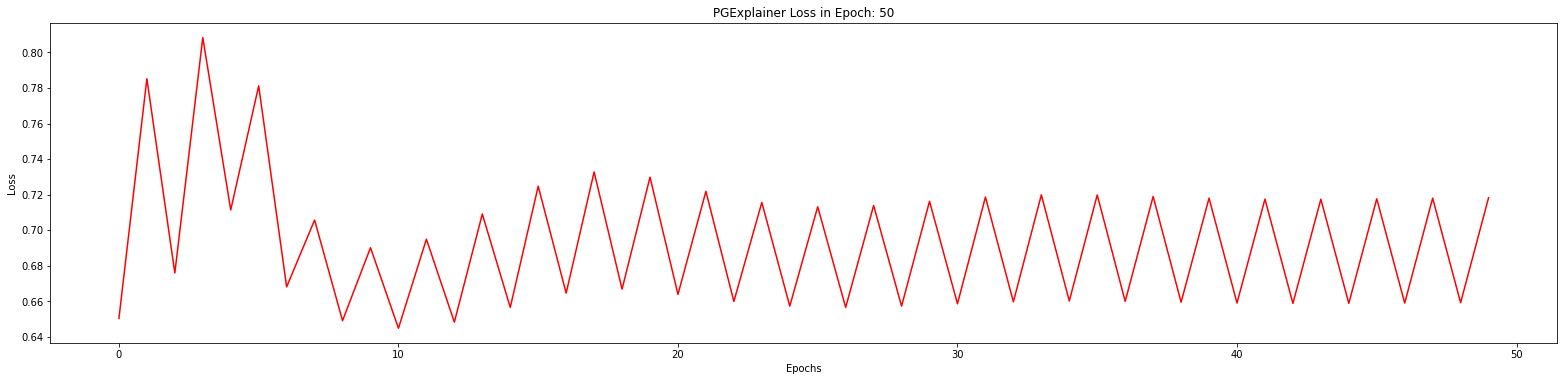

Epoch: 051, PGExplainer Model Loss: 0.6594
Epoch: 052, PGExplainer Model Loss: 0.7184
Epoch: 053, PGExplainer Model Loss: 0.6594
Epoch: 054, PGExplainer Model Loss: 0.7183
Epoch: 055, PGExplainer Model Loss: 0.6593
Epoch: 056, PGExplainer Model Loss: 0.7182
Epoch: 057, PGExplainer Model Loss: 0.6592
Epoch: 058, PGExplainer Model Loss: 0.7181
Epoch: 059, PGExplainer Model Loss: 0.6592
Epoch: 060, PGExplainer Model Loss: 0.7180
Epoch: 061, PGExplainer Model Loss: 0.6592
Epoch: 062, PGExplainer Model Loss: 0.7181
Epoch: 063, PGExplainer Model Loss: 0.6592
Epoch: 064, PGExplainer Model Loss: 0.7181
Epoch: 065, PGExplainer Model Loss: 0.6592
Epoch: 066, PGExplainer Model Loss: 0.7181
Epoch: 067, PGExplainer Model Loss: 0.6592
Epoch: 068, PGExplainer Model Loss: 0.7182
Epoch: 069, PGExplainer Model Loss: 0.6593
Epoch: 070, PGExplainer Model Loss: 0.7182
Epoch: 071, PGExplainer Model Loss: 0.6593
Epoch: 072, PGExplainer Model Loss: 0.7181
Epoch: 073, PGExplainer Model Loss: 0.6592
Epoch: 074,

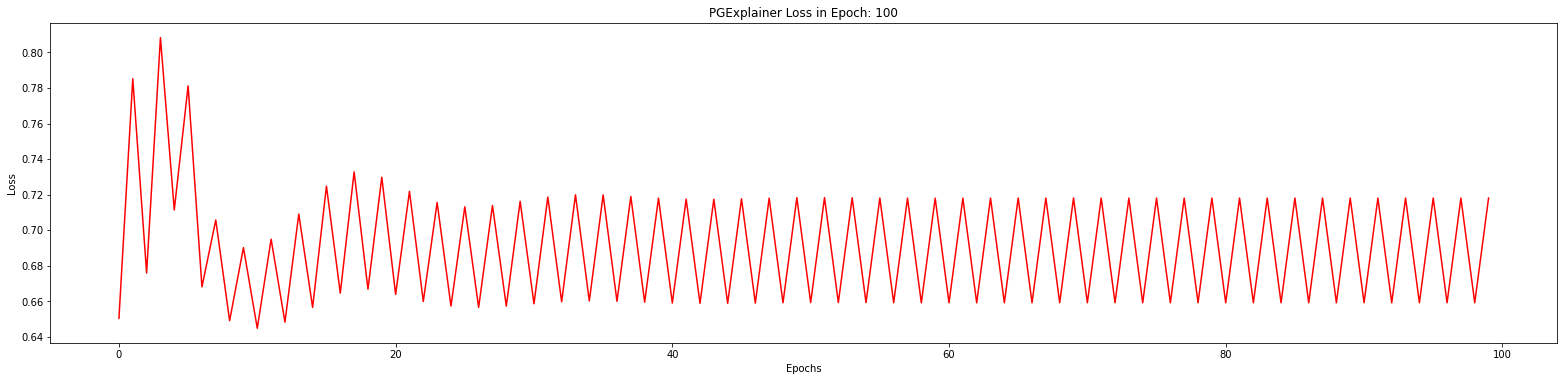

Epoch: 101, PGExplainer Model Loss: 0.6592
Epoch: 102, PGExplainer Model Loss: 0.7181
Epoch: 103, PGExplainer Model Loss: 0.6592
Epoch: 104, PGExplainer Model Loss: 0.7181
Epoch: 105, PGExplainer Model Loss: 0.6592
Epoch: 106, PGExplainer Model Loss: 0.7181
Epoch: 107, PGExplainer Model Loss: 0.6592
Epoch: 108, PGExplainer Model Loss: 0.7181
Epoch: 109, PGExplainer Model Loss: 0.6592
Epoch: 110, PGExplainer Model Loss: 0.7181
Epoch: 111, PGExplainer Model Loss: 0.6592
Epoch: 112, PGExplainer Model Loss: 0.7181
Epoch: 113, PGExplainer Model Loss: 0.6592
Epoch: 114, PGExplainer Model Loss: 0.7181
Epoch: 115, PGExplainer Model Loss: 0.6592
Epoch: 116, PGExplainer Model Loss: 0.7181
Epoch: 117, PGExplainer Model Loss: 0.6592
Epoch: 118, PGExplainer Model Loss: 0.7181
Epoch: 119, PGExplainer Model Loss: 0.6592
Epoch: 120, PGExplainer Model Loss: 0.7181
Epoch: 121, PGExplainer Model Loss: 0.6592
Epoch: 122, PGExplainer Model Loss: 0.7181
Epoch: 123, PGExplainer Model Loss: 0.6592
Epoch: 124,

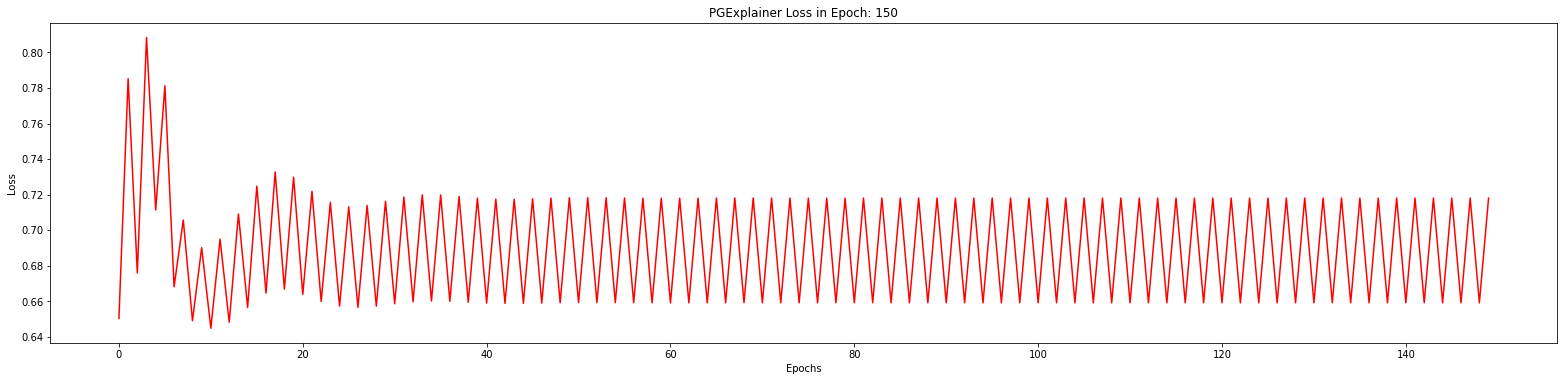

Epoch: 151, PGExplainer Model Loss: 0.6592
Epoch: 152, PGExplainer Model Loss: 0.7181
Epoch: 153, PGExplainer Model Loss: 0.6592
Epoch: 154, PGExplainer Model Loss: 0.7181
Epoch: 155, PGExplainer Model Loss: 0.6592
Epoch: 156, PGExplainer Model Loss: 0.7181
Epoch: 157, PGExplainer Model Loss: 0.6592
Epoch: 158, PGExplainer Model Loss: 0.7181
Epoch: 159, PGExplainer Model Loss: 0.6592
Epoch: 160, PGExplainer Model Loss: 0.7181
Epoch: 161, PGExplainer Model Loss: 0.6592
Epoch: 162, PGExplainer Model Loss: 0.7181
Epoch: 163, PGExplainer Model Loss: 0.6592
Epoch: 164, PGExplainer Model Loss: 0.7181
Epoch: 165, PGExplainer Model Loss: 0.6592
Epoch: 166, PGExplainer Model Loss: 0.7181
Epoch: 167, PGExplainer Model Loss: 0.6592
Epoch: 168, PGExplainer Model Loss: 0.7181
Epoch: 169, PGExplainer Model Loss: 0.6592
Epoch: 170, PGExplainer Model Loss: 0.7181
Epoch: 171, PGExplainer Model Loss: 0.6592
Epoch: 172, PGExplainer Model Loss: 0.7181
Epoch: 173, PGExplainer Model Loss: 0.6592
Epoch: 174,

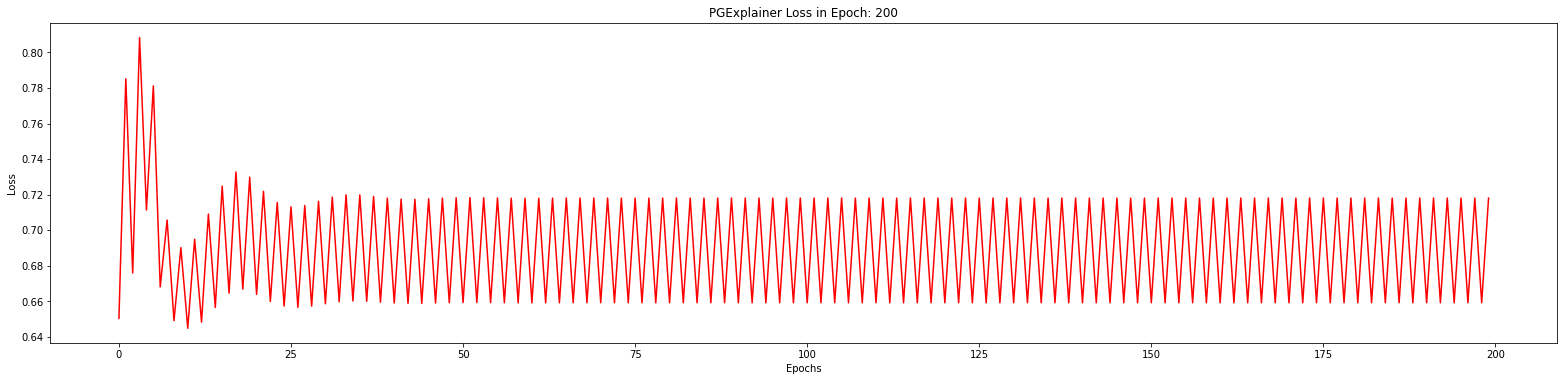

In [107]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [108]:
GCN_Model_test_predicted_labels = []
def GCN_Model_test(test_loader):
  GCN_Model.eval()
  #DIG_Model.eval()
  correct = 0
  for g in test_dataset:
    GCN_Model_test_out = GCN_Model(g.x, g.edge_index)
    GCN_Model_test_pred = GCN_Model_test_out.argmax(dim=1) 
    GCN_Model_test_predicted_labels.append(GCN_Model_test_pred)
    correct += int((GCN_Model_test_pred == g.y).sum())  
  return correct / len(test_dataset), GCN_Model_test_predicted_labels 

In [109]:
GCN_Model_test_acc, predicted_labels = GCN_Model_test(test_dataset)
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.3860


# **PGExplainer**

In [119]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [118]:
explainer = PGExplainer(GCN_Model, in_channels=14, device=device, explain_graph=True, num_hops=1, epochs=10)

In [121]:
print(test_dataset[0])
#print(test_dataset[0].edge_attr)

Data(edge_index=[2, 34], x=[15, 7], edge_attr=[34, 4], y=[1])


In [120]:
explainer.train_explanation_network(test_dataset)

100%|██████████| 57/57 [00:00<00:00, 319.92it/s]


Epoch: 0 | Loss: 44.60414582490921


100%|██████████| 57/57 [00:00<00:00, 331.50it/s]


Epoch: 1 | Loss: 44.48948174715042


100%|██████████| 57/57 [00:00<00:00, 320.58it/s]


Epoch: 2 | Loss: 44.389140605926514


100%|██████████| 57/57 [00:00<00:00, 290.08it/s]


Epoch: 3 | Loss: 44.35491859912872


100%|██████████| 57/57 [00:00<00:00, 338.17it/s]


Epoch: 4 | Loss: 44.33286261558533


100%|██████████| 57/57 [00:00<00:00, 324.95it/s]


Epoch: 5 | Loss: 44.2545650601387


100%|██████████| 57/57 [00:00<00:00, 325.30it/s]


Epoch: 6 | Loss: 44.20886641740799


100%|██████████| 57/57 [00:00<00:00, 320.75it/s]


Epoch: 7 | Loss: 44.0517657995224


100%|██████████| 57/57 [00:00<00:00, 325.55it/s]


Epoch: 8 | Loss: 43.93748152256012


100%|██████████| 57/57 [00:00<00:00, 309.96it/s]

Epoch: 9 | Loss: 43.337098240852356


In [130]:
Masks = []
for i in range(len(test_dataset)):
  with torch.no_grad():
    walks, masks, related_preds = explainer(test_dataset[i].x, test_dataset[i].edge_index, y=test_dataset[i].y)
    

    for mask in masks:
      Masks.append(mask.detach().numpy().tolist())

print(len(Masks[0]))
print(len(test_dataset[0].edge_index[0]))

34
34
